# Árboles de Decisión para Clasificación

## Fundamentos Teóricos

### Árboles de Decisión
Los árboles de decisión son modelos que dividen el espacio de características en regiones mediante una serie de reglas de decisión. Para clasificación:

- Utilizan métricas como Gini o Entropía para decidir las divisiones
- Son interpretables pero tienden al sobreajuste
- Pueden visualizarse fácilmente

# Métricas de División en Árboles de Decisión

## Índice Gini y Entropía: Fundamentos Matemáticos

### Índice Gini
El índice Gini mide la impureza o heterogeneidad en un nodo. Para un conjunto de datos con $c$ clases:

$$ Gini = 1 - \sum_{i=1}^{c} (p_i)^2 $$

Donde:
- $p_i$ es la proporción de muestras de la clase $i$ en el nodo
- Rango: [0, 1]
- 0: nodo puro (todas las muestras son de la misma clase)
- 1 - 1/c: máxima impureza

#### Ejemplo de Gini
Para un nodo con 100 muestras:
- 60 clase A
- 40 clase B

$$ Gini = 1 - (\frac{60}{100})^2 - (\frac{40}{100})^2 = 0.48 $$

### Entropía
La entropía mide el desorden o incertidumbre en un nodo:

$$ Entropy = -\sum_{i=1}^{c} p_i \log_2(p_i) $$

Donde:
- $p_i$ es la proporción de muestras de la clase $i$
- Rango: [0, $\log_2(c)$]
- 0: nodo puro
- $\log_2(c)$: máxima entropía (distribución uniforme)

#### Ejemplo de Entropía
Para el mismo nodo:

$$ Entropy = -\frac{60}{100}\log_2(\frac{60}{100}) - \frac{40}{100}\log_2(\frac{40}{100}) = 0.971 $$

### Ganancia de Información
La ganancia de información mide la reducción en impureza después de una división:

$$ IG = I_{parent} - \sum_{j=1}^{k} \frac{n_j}{n} I_{child_j} $$

Donde:
- $I$ es la métrica de impureza (Gini o Entropía)
- $n_j$ es el número de muestras en el hijo $j$
- $n$ es el número de muestras en el nodo padre
- $k$ es el número de nodos hijos

### Comparación
1. **Gini**:
   - Computacionalmente más eficiente
   - Favorece divisiones más grandes
   - Más sensible a cambios en las probabilidades medias

2. **Entropía**:
   - Penaliza más la heterogeneidad
   - Produce árboles más balanceados
   - Más costosa computacionalmente

El árbol selecciona la división que maximice la ganancia de información, ya sea usando Gini o Entropía como métrica de impureza.

In [1]:
# Clonar el repositorio y cambiar de directorio
!git clone https://github.com/davidjamesknight/SQLite_databases_for_learning_data_science
%cd SQLite_databases_for_learning_data_science

fatal: destination path 'SQLite_databases_for_learning_data_science' already exists and is not an empty directory.
/Users/jorgeramirez/Documents/Python Projects/4 Modelos Predictivos Avanzados/SQLite_databases_for_learning_data_science


In [2]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import plotly.figure_factory as ff

# Conectar a la base de datos y obtener el dataset
conn = sqlite3.connect('iris.db')

query = """
SELECT 
    O.sepal_length,
    O.sepal_width,
    O.petal_length,
    O.petal_width,
    S.species
FROM 
    Observation AS O
JOIN 
    Species AS S ON S.species_id = O.species_id
"""

df = pd.read_sql_query(query, conn)
conn.close()

# Mostrar las primeras filas
print("Muestra del dataset:")
df.head()

Muestra del dataset:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [5]:
def remove_outliers(df):
    """
    Remove outliers from all numeric columns in the dataframe and log the results.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    
    Returns
    -------
    pd.DataFrame
        Dataframe with outliers removed from all numeric columns
    """
    
    # Create a copy of the dataframe
    df_clean = df.copy()
    
    # Get numeric columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    outliers_log = {}
    
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        
        mask = (df[column] < lower_bound) | (df[column] > upper_bound)
        
        if mask.any():
            outlier_count = mask.sum()
            percent_outlier = round((outlier_count / len(df)) * 100, 2)
            outliers_log[column] = {
                'count': outlier_count,
                'percentage': percent_outlier
            }
            
            df_clean = df_clean[~mask]
            
    # Print summary
    for column, stats in outliers_log.items():
        print(f'Variable "{column}": {stats["count"]} outliers removidos ({stats["percentage"]}% de la data)')
    
    if not outliers_log:
        print("No se encontraron outliers en ninguna columna.")
        
    return df_clean

df = remove_outliers(df)

Variable "sepal_width": 4 outliers removidos (2.67% de la data)


In [6]:
# Análisis exploratorio
import plotly.express as px

# Visualizar distribución de características por especie
def plot_feature_distribution(df, feature):
    fig = px.box(df, x='species', y=feature, 
                 title=f'Distribución de {feature} por Especie')
    fig.show()

for feature in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
    plot_feature_distribution(df, feature)

# Matriz de dispersión
fig = px.scatter_matrix(df, 
                       dimensions=['sepal_length', 'sepal_width', 
                                 'petal_length', 'petal_width'],
                       color='species',
                       title='Matriz de Dispersión del Dataset Iris')
fig.update_layout(
    #width=800,
    height=800,
    title_font_size=20
)
fig.show()

In [7]:
# Preparación de datos

# Separar características y target
X = df.drop('species', axis=1)
y = df['species']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Entrenar árbol de decisión
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [9]:
# Predicciones/Inferencia
y_pred_dt = dt_clf.predict(X_test)

# Evaluación
print("Reporte de Clasificación - Árbol de Decisión:")
print(classification_report(y_test, y_pred_dt))

Reporte de Clasificación - Árbol de Decisión:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.80      0.89        10
   virginica       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



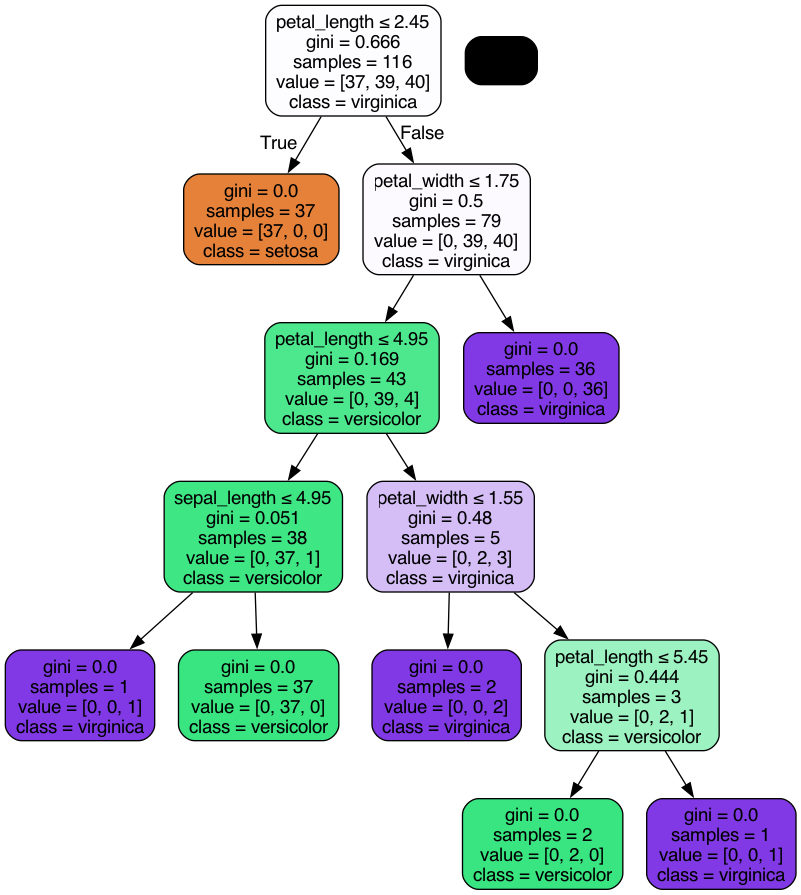

In [10]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Export the decision tree to dot format
dot_data = export_graphviz(
    dt_clf,  # use the existing trained decision tree classifier
    out_file=None,
    feature_names=X.columns,
    class_names=sorted(y.unique()),
    filled=True,
    rounded=True,
    special_characters=True
)

# Convert dot data to graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Display the tree
Image(graph.create_png())

In [11]:
# Visualizar matriz de confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(list(set(y_true)))
    
    fig = ff.create_annotated_heatmap(
        z=cm,
        x=labels,
        y=labels,
        colorscale='Viridis',
        showscale=True
    )
    
    fig.update_layout(
        title=title,
        xaxis_title="Predicho",
        yaxis_title="Real"
    )
    
    fig.show()

plot_confusion_matrix(y_test, y_pred_dt, "Matriz de Confusión - Árbol de Decisión")

In [12]:
from sklearn.model_selection import cross_val_score

# Validación cruzada con 5 folds
scores = cross_val_score(
    dt_clf,
    X_test,
    y_test,
    cv=5,
    scoring='accuracy'
)

print(f"Precisión promedio (cross-validation): {scores.mean():.3f}")
print(f"Desviación estándar: {scores.std():.3f}")

Precisión promedio (cross-validation): 0.867
Desviación estándar: 0.125


In [13]:
# Visualización de importancia de características
importances_dt = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_clf.feature_importances_
}).sort_values('importance', ascending=False)

fig = px.bar(
    importances_dt,
    x='feature',
    y='importance',
    title='Importancia de Características - Árbol de Decisión'
)
fig.show()